# Week 4: Handling Complex Images - Happy or Sad Dataset

In this assignment you will be using the happy or sad dataset, which contains 80 images of emoji-like faces, 40 happy and 40 sad.

Create a convolutional neural network that trains to 99.9% accuracy on these images,  which cancels training upon hitting this training accuracy threshold.

In [6]:
# IMPORTANT: This will check your notebook's metadata for grading.
# Please do not continue the lab unless the output of this cell tells you to proceed.
!python add_metadata.py --filename C1W4_Assignment.ipynb

python3: can't open file '/content/add_metadata.py': [Errno 2] No such file or directory


_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete non-graded cells in this notebook . Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and also refrain from adding any new cells. **Once you have passed this assignment** and want to experiment with any of the non-graded code, you may follow the instructions at the bottom of this notebook._

In [30]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img


## Load and explore the data

Begin by taking a look at some images of the dataset.

Notice that all the images are contained within the `./data/` directory.

This directory contains two subdirectories `happy/` and `sad/` and each image is saved under the subdirectory related to the class it belongs to.

Sample happy image:


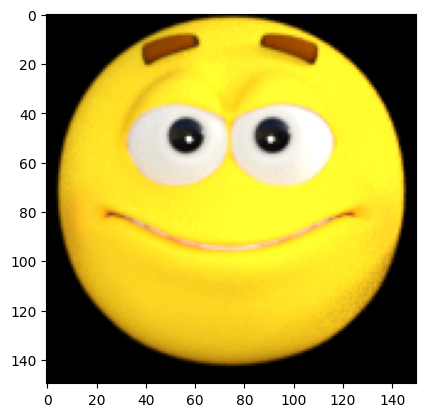


Sample sad image:


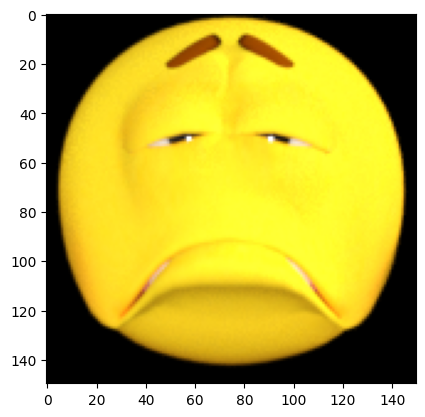

In [31]:

base_dir = "./data/"
happy_dir = os.path.join(base_dir, "happy/")
sad_dir = os.path.join(base_dir, "sad/")

print("Sample happy image:")
plt.imshow(load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}"))
plt.show()

print("\nSample sad image:")
plt.imshow(load_img(f"{os.path.join(sad_dir, os.listdir(sad_dir)[0])}"))
plt.show()

It is cool to be able to see examples of the images to better understand the problem-space you are dealing with.

However there is still some relevant information that is missing such as the resolution of the image (although matplotlib renders the images in a grid providing a good idea of these values) and the maximum pixel value (this is important for normalizing these values). For this you can use Keras as shown in the next cell:

In [32]:
# grader-required-cell

from tensorflow.keras.preprocessing.image import img_to_array

# Load the first example of a happy face
sample_image  = load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")



Each image has shape: (150, 150, 3)
The maximum pixel value used is: 255.0


Looks like the images have a resolution of 150x150. **This is very important because this will be the input size of the first layer in your network.**

**The last dimension refers to each one of the 3 RGB channels that are used to represent colored images.**

## Defining the callback

Since you already have coded the callback responsible for stopping training (once a desired level of accuracy is reached) in the previous two assignments this time it is already provided so you can focus on the other steps:

In [33]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.999:
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

A quick note on callbacks:

So far you have used only the `on_epoch_end` callback but there are many more. For example you might want to check out the [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback, which allows you to save the best weights for your model.

## Pre-processing the data

Keras provides great support for preprocessing image data. A lot can be accomplished by using the `ImageDataGenerator` class. Be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) if you get stuck in the next exercise. In particular you might want to pay attention to the `rescale` argument when instantiating the `ImageDataGenerator` and to the [`flow_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) method.

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def image_generator(base_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    train_generator = train_datagen.flow_from_directory(
        directory=base_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary'
    )

    return train_generator

In [35]:
# grader-required-cell

# Save your generator in a variable
gen = image_generator(base_dir='data')


Found 80 images belonging to 3 classes.


**Expected Output:**
```
Found 80 images belonging to 2 classes.
```

## Creating and training your model

Finally, complete the `train_happy_sad_model` function below. This function should return your  neural network.

**Your model should achieve an accuracy of 99.9% or more before 15 epochs to pass this assignment.**

**Hints:**
- You can try any architecture for the network but keep in mind that the model will work best with 3 convolutional layers.


- In case you need extra help you can check out some tips at the end of this notebook.

In [36]:
from tensorflow.keras import optimizers, losses

def train_happy_sad_model(train_generator):
    callbacks = myCallback()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    history = model.fit(x=train_generator,
                        epochs=15,
                        callbacks=[callbacks])

    return history

In [37]:
# grader-required-cell

hist = train_happy_sad_model(gen)

Epoch 1/15
8/8 [==============================] - 13s 255ms/step - loss: -26.5302 - accuracy: 0.4250
Epoch 2/15
8/8 [==============================] - 2s 256ms/step - loss: -873.0165 - accuracy: 0.5000
Epoch 3/15
8/8 [==============================] - 3s 409ms/step - loss: -14314.3467 - accuracy: 0.5000
Epoch 4/15
8/8 [==============================] - 2s 251ms/step - loss: -126166.0859 - accuracy: 0.5000
Epoch 5/15
8/8 [==============================] - 2s 257ms/step - loss: -717373.4375 - accuracy: 0.5000
Epoch 6/15
8/8 [==============================] - 2s 254ms/step - loss: -3600788.0000 - accuracy: 0.5000
Epoch 7/15
8/8 [==============================] - 2s 278ms/step - loss: -13020030.0000 - accuracy: 0.5000
Epoch 8/15
8/8 [==============================] - 3s 335ms/step - loss: -46324084.0000 - accuracy: 0.5000
Epoch 9/15
8/8 [==============================] - 2s 255ms/step - loss: -120746320.0000 - accuracy: 0.5000
Epoch 10/15
8/8 [==============================] - 2s 256ms/ste

If you see the message that was defined in the callback printed out after less than 15 epochs it means your callback worked as expected and training was successful. You can also double check by running the following cell:

In [38]:
# grader-required-cell

print(f"Your model reached the desired accuracy after {len(hist.epoch)} epochs")

Your model reached the desired accuracy after 15 epochs


If your callback didn't stop training, one cause might be that you compiled your model using a metric other than `accuracy` (such as `acc`). Make sure you set the metric to `accuracy`. You can check by running the following cell:

In [40]:
if not "accuracy" in hist.model.metrics_names:
    print("Use 'accuracy' as metric when compiling your model.")
else:
    print("The metric was correctly defined.")

The metric was correctly defined.


## Need more help?

Run the following cell to see some extra tips for the model's architecture.

In [41]:
import base64

encoded_answer = "ClNvbWUgaGVscGZ1bCB0aXBzIGluIGNhc2UgeW91IGFyZSBzdHVjazoKCiAgICAtIEEgZ29vZCBmaXJzdCBsYXllciB3b3VsZCBiZSBhIENvbnYyRCBsYXllciB3aXRoIGFuIGlucHV0IHNoYXBlIHRoYXQgbWF0Y2hlcyAKICAgIHRoYXQgb2YgZXZlcnkgaW1hZ2UgaW4gdGhlIHRyYWluaW5nIHNldCAoaW5jbHVkaW5nIHRoZSBjb2xvciBkaW1lbnNpb24pCiAgICAKICAgIC0gVGhlIG1vZGVsIHdpbGwgd29yayBiZXN0IHdpdGggMyBjb252b2x1dGlvbmFsIGxheWVycwogICAgCiAgICAtIFRoZXJlIHNob3VsZCBiZSBhIEZsYXR0ZW4gbGF5ZXIgaW4gYmV0d2VlbiBjb252b2x1dGlvbmFsIGFuZCBkZW5zZSBsYXllcnMKICAgIAogICAgLSBUaGUgZmluYWwgbGF5ZXIgc2hvdWxkIGJlIGEgRGVuc2UgbGF5ZXIgd2l0aCB0aGUgbnVtYmVyIG9mIHVuaXRzIGFuZCAKICAgIGFjdGl2YXRpb24gZnVuY3Rpb24gdGhhdCBzdXBwb3J0cyBiaW5hcnkgY2xhc3NpZmljYXRpb24uCg=="
encoded_answer = encoded_answer.encode('ascii')
answer = base64.b64decode(encoded_answer)
answer = answer.decode('ascii')

print(answer)


Some helpful tips in case you are stuck:

    - A good first layer would be a Conv2D layer with an input shape that matches 
    that of every image in the training set (including the color dimension)
    
    - The model will work best with 3 convolutional layers
    
    - There should be a Flatten layer in between convolutional and dense layers
    
    - The final layer should be a Dense layer with the number of units and 
    activation function that supports binary classification.



**Congratulations on finishing the last assignment of this course!**

You have successfully implemented a CNN to assist you in the classification task for complex images. Nice job!

**Keep it up!**

<details>
  <summary><font size="2" color="darkgreen"><b>Please click here if you want to experiment with any of the non-graded code.</b></font></summary>
    <p><i><b>Important Note: Please only do this when you've already passed the assignment to avoid problems with the autograder.</b></i>
    <ol>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “Edit Metadata”</li>
        <li> Hit the “Edit Metadata” button next to the code cell which you want to lock/unlock</li>
        <li> Set the attribute value for “editable” to:
            <ul>
                <li> “true” if you want to unlock it </li>
                <li> “false” if you want to lock it </li>
            </ul>
        </li>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “None” </li>
    </ol>
    <p> Here's a short demo of how to do the steps above:
        <br>
        <img src="https://drive.google.com/uc?export=view&id=14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1" align="center">
</details>